In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
import re 
import nltk
import emoji


import os
import sys
import string
import unicodedata
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from spellchecker import SpellChecker
from nltk.tokenize import sent_tokenize, word_tokenize
from langid.langid import LanguageIdentifier, model


from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from Helper import *

import spacy
import scattertext as st

%matplotlib inline
plt.style.use('ggplot')

In [7]:
file_path = '../../../../Downloads/concatenated_abridged.jsonl'

In [8]:
#Reading in the json file

with open(file_path, 'r') as json_file:
    json_strings = list(json_file)
json_list = []
for tweet in json_strings:
    json_list.append(json.loads(tweet))
df = pd.DataFrame(json_list)

In [9]:
# Creating a copy of the dataframe to work off of 
tweet_df = df.copy()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140337 entries, 0 to 140336
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   created_at                 140337 non-null  object 
 1   id                         140337 non-null  int64  
 2   id_str                     140337 non-null  object 
 3   full_text                  140337 non-null  object 
 4   truncated                  140337 non-null  bool   
 5   display_text_range         140337 non-null  object 
 6   entities                   140337 non-null  object 
 7   source                     140337 non-null  object 
 8   in_reply_to_status_id      19112 non-null   float64
 9   in_reply_to_status_id_str  19112 non-null   object 
 10  in_reply_to_user_id        20181 non-null   float64
 11  in_reply_to_user_id_str    20181 non-null   object 
 12  in_reply_to_screen_name    20181 non-null   object 
 13  user                       14

In [11]:
#Selecting columns I want to work with
tweet_df = tweet_df[['created_at', 'id','full_text','display_text_range','entities','user', 'retweet_count', 'favorite_count','favorited','retweeted','lang']]

In [12]:
# Extracting username from the user's profile information
tweet_df['user_description'] = tweet_df.user.apply(lambda x: x['description'])

tweet_df = tweet_df[['created_at', 'id','user_description','full_text','display_text_range','entities','user', 'retweet_count', 'favorite_count','lang']]

In [13]:
# Grabbing the value that depicts the length of the tweet.
tweet_df.display_text_range = tweet_df.display_text_range.apply(lambda x: x[-1])

In [14]:
# Renaming columns to provide a better description of each column's contents
tweet_df.columns =['created_at', 'id','user_description','full_text','tweet_length','entities','user', 'retweet_count', 'favorite_count','lang']

In [15]:
# Converting created_at to date time
tweet_df.created_at = pd.to_datetime(tweet_df.created_at)

In [30]:
sentiment_analyzer = SentimentIntensityAnalyzer()

def sentiment_analysis(text):
    return sentiment_analyzer.polarity_scores(text)['compound']

sentiment_analysis('I love it!')

0.6696

In [32]:
president_mentioned = []
for i in tweet_df.full_text:
    """
    Created an additional column to label which candidate was mentioned in their tweets.
    """
    if (('donald' in i.lower()) and ('biden' in i.lower())) or (('donald' in i.lower()) and ('joe' in i.lower())) or \
        (('trump' in i.lower()) and ('biden' in i.lower())) or (('trump' in i.lower()) and ('joe' in i.lower())):
            president_mentioned.append('trump and biden')
    elif ('donald' in i.lower()) or ('trump' in i.lower()) or ('donaldtrump' in i.lower()):
        president_mentioned.append('trump')
    elif ('biden' in i.lower()) or ('joe' in i.lower()) or ('joebiden' in i.lower()):
        president_mentioned.append('biden')
    else:
        president_mentioned.append('no_candidate')


In [33]:
tweet_df['president_mentioned'] = president_mentioned
tweet_df['preprocessed_text'] = tweet_df.full_text.apply(lambda x: preprocessing(x))
tweet_df.preprocessed_text = tweet_df.preprocessed_text.apply(lambda x: " ".join(x))
tweet_df['sentiment'] = tweet_df.preprocessed_text.apply(lambda x: sentiment_analysis(x))

In [35]:
sentiment_tweets = tweet_df.copy()
sentiment_tweets.created_at = sentiment_tweets.created_at.apply(lambda x: x.date())
sentiment_tweets.created_at = sentiment_tweets.astype('str')
sentiment_tweets = sentiment_tweets[sentiment_tweets.created_at != '2020-09-29']

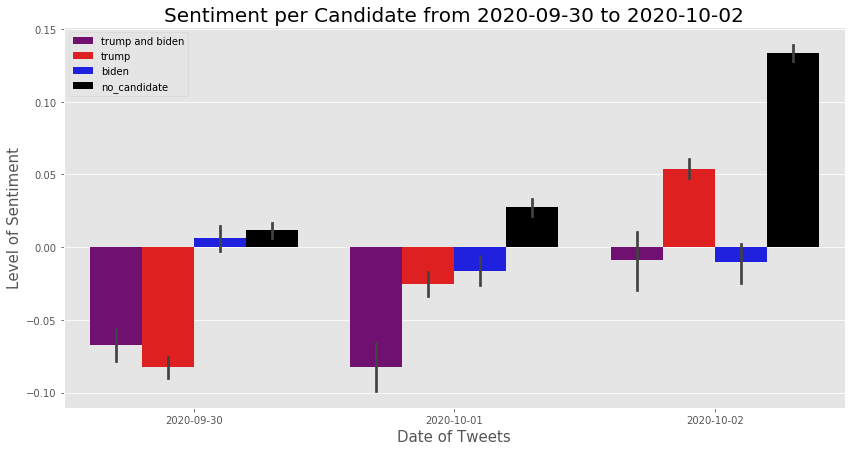

In [98]:
fig, ax = plt.subplots(figsize = (14, 7))

sns.barplot(x = 'created_at', y = 'sentiment', data=sentiment_tweets, hue='president_mentioned',palette = ['purple','red','blue','black'])
ax.legend(fontsize = 10)
ax.set_title('Sentiment per Candidate from 2020-09-30 to 2020-10-02', fontsize = 20)
ax.set_xlabel('Date of Tweets', fontsize = 15)
ax.set_ylabel('Level of Sentiment', fontsize = 15)
plt.grid(True, axis = 'y');

plt.savefig('../img/Sentiment_per_candidate.png')

In [45]:
positive_sentiment = sentiment_tweets[sentiment_tweets.sentiment > 0]
negative_sentiment = sentiment_tweets[sentiment_tweets.sentiment < 0]

In [101]:
positive_sentiment = pd.DataFrame(positive_sentiment.groupby(['created_at', 'president_mentioned']).count()['sentiment']).reset_index()
positive_sentiment.columns = ['created_at','president_mentioned','positive_sentiment']

KeyError: 'sentiment'

In [102]:
negative_sentiment = pd.DataFrame(negative_sentiment.groupby(['created_at', 'president_mentioned']).count()['sentiment']).reset_index()
negative_sentiment.columns = ['created_at','president_mentioned','negative_sentiment']

KeyError: 'sentiment'

In [50]:
sentiment_count = pd.merge(positive_sentiment, negative_sentiment)

In [51]:
sentiment_count = pd.melt(sentiment_count, ['created_at','president_mentioned'])

In [52]:
sentiment_count

,created_at,president_mentioned,variable,value
0,2020-09-30,biden,positive_sentiment,3259
1,2020-09-30,no_candidate,positive_sentiment,6642
2,2020-09-30,trump,positive_sentiment,4030
3,2020-09-30,trump and biden,positive_sentiment,1427
4,2020-10-01,biden,positive_sentiment,2422
5,2020-10-01,no_candidate,positive_sentiment,8099
6,2020-10-01,trump,positive_sentiment,4763
7,2020-10-01,trump and biden,positive_sentiment,849
8,2020-10-02,biden,positive_sentiment,1238
9,2020-10-02,no_candidate,positive_sentiment,10985


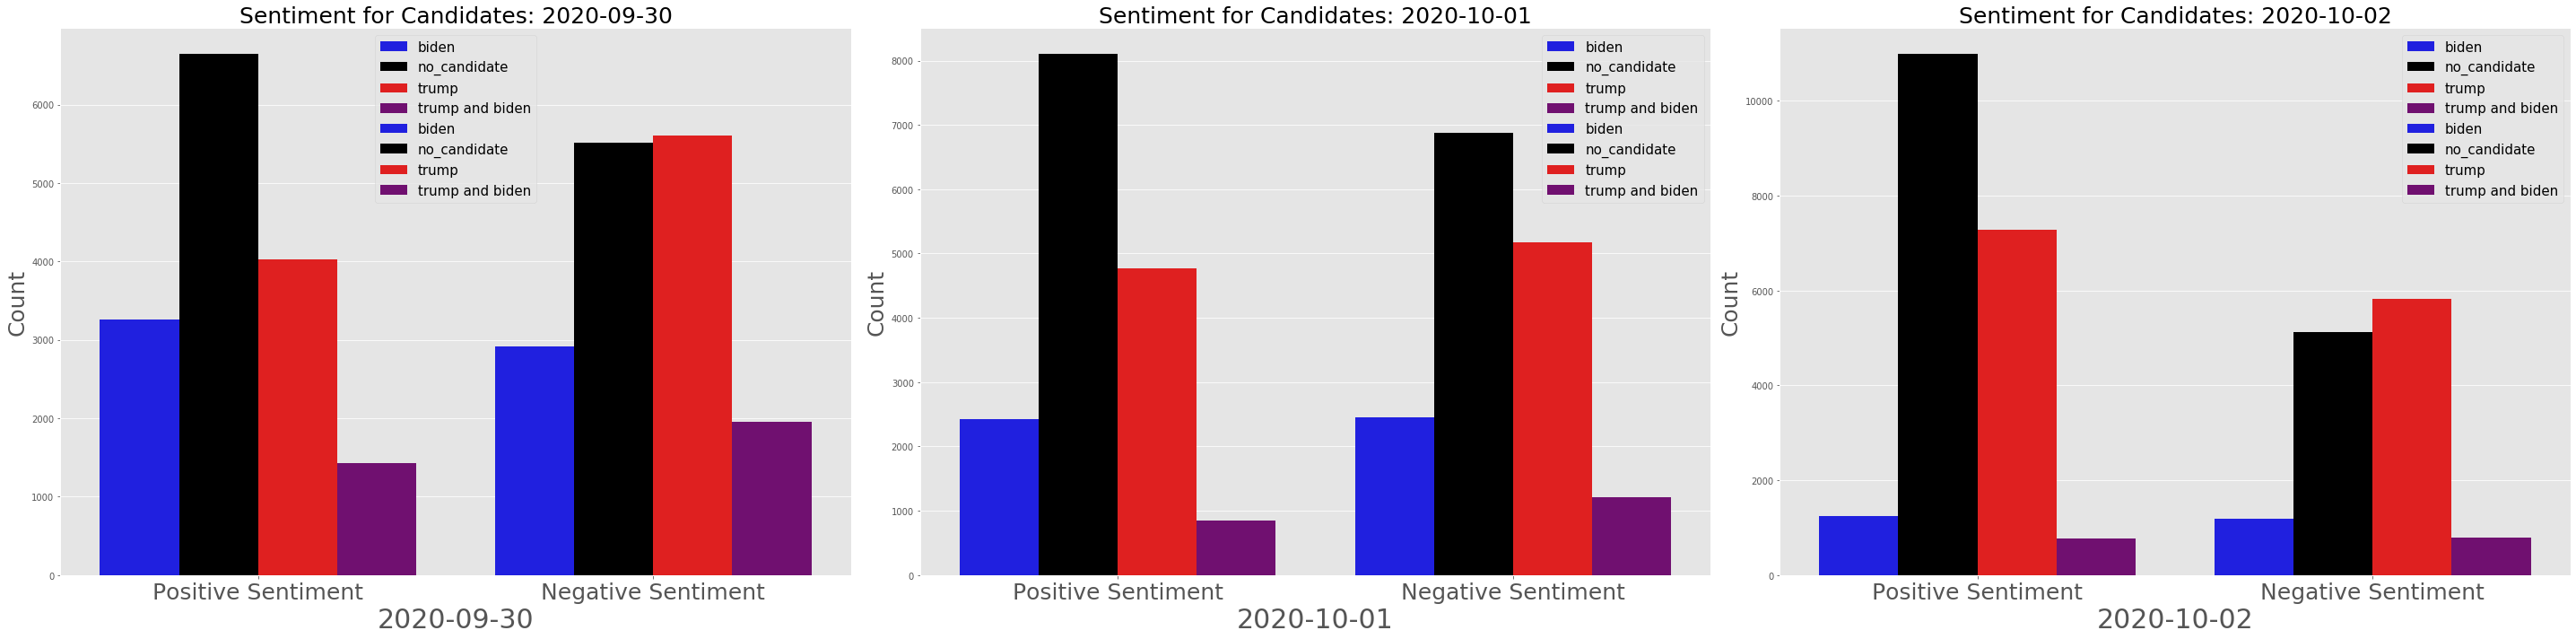

In [89]:
fig, axs = plt.subplots(1, 3, figsize = (40,10))

dates = ['2020-09-30','2020-10-01','2020-10-02']
for (ax, date) in zip(axs.flat, dates):
    sns.barplot(x = sentiment_count[sentiment_count.created_at == date].variable,
                y = sentiment_count[sentiment_count.created_at == date].value, 
                hue = sentiment_count[sentiment_count.created_at == date].president_mentioned, palette = ['blue','black','red','purple'], ax=ax)
    sns.barplot(x = sentiment_count[sentiment_count.created_at == date].variable,
                y = sentiment_count[sentiment_count.created_at == date].value, 
                hue = sentiment_count[sentiment_count.created_at == date].president_mentioned, palette = ['blue','black','red','purple'], ax=ax)
    ax.set_title('Sentiment for Candidates: {}'.format(date), fontsize = 25)
    ax.set_xlabel('{}'.format(date), fontsize = 30)
    ax.set_xticklabels(['Positive Sentiment','Negative Sentiment'],fontdict = {'fontsize':25})
    ax.set_ylabel('Count', fontsize = 25)
    ax.legend(fontsize = 15)
    
plt.tight_layout()
# plt.savefig('../imgs/sentiment_counts.png', dpi=800)

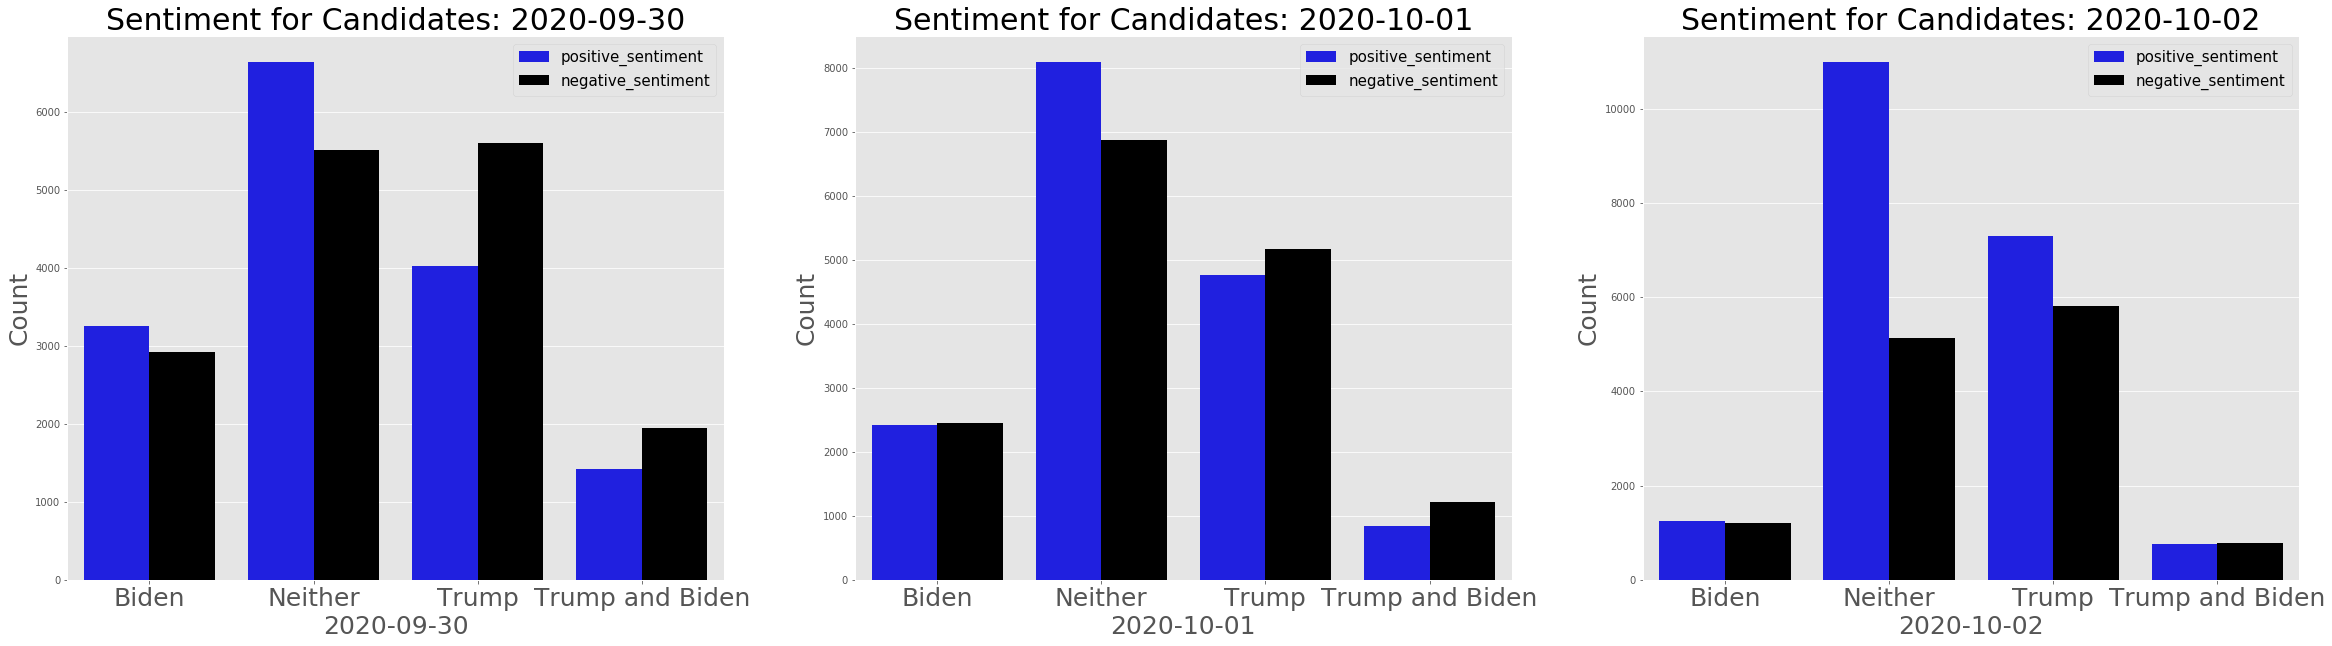

In [100]:
fig, axs = plt.subplots(1, 3, figsize = (40,10))

dates = ['2020-09-30','2020-10-01','2020-10-02']
for (ax, date) in zip(axs.flat, dates):
    sns.barplot(x = sentiment_count[sentiment_count.created_at == date].president_mentioned,
                y = sentiment_count[sentiment_count.created_at == date].value, 
                hue = sentiment_count[sentiment_count.created_at == date].variable, palette = ['blue','black'], ax=ax)
    ax.set_title('Sentiment for Candidates: {}'.format(date), fontsize = 30)
    ax.set_xlabel('{}'.format(date), fontsize = 25)
    ax.set_xticklabels(labels = ['Biden','Neither','Trump','Trump and Biden'],fontdict = {'fontsize':25})
    ax.set_ylabel('Count', fontsize = 25)
    ax.legend(fontsize = 15)
    
plt.savefig('../img/sentiment_counts.png')

In [56]:
sentiment_tweets.preprocessed_text = sentiment_tweets.preprocessed_text.apply(lambda x: preprocessing(x))

In [57]:
sentiment_tweets.preprocessed_text = sentiment_tweets.preprocessed_text.apply(lambda x: " ".join(x))

In [63]:
trump_negative = sentiment_tweets[(sentiment_tweets.sentiment < 0) & (sentiment_tweets.president_mentioned == 'trump')]
trump_positive = sentiment_tweets[(sentiment_tweets.sentiment >= 0) & (sentiment_tweets.president_mentioned == 'trump')]

biden_negative = sentiment_tweets[(sentiment_tweets.sentiment < 0) & (sentiment_tweets.president_mentioned == 'biden')]
biden_positive = sentiment_tweets[(sentiment_tweets.sentiment >= 0) & (sentiment_tweets.president_mentioned == 'biden')]

In [59]:
from collections import Counter
Counter(" ".join(trump_negative['preprocessed_text']).split()).most_common(10)

[('condemn', 1526),
 ('covid', 1510),
 ('get', 1339),
 ('supremacy', 1094),
 ('supremacist', 1054),
 ('refuse', 841),
 ('racist', 769),
 ('one', 744),
 ('time', 740),
 ('bad', 728)]

In [60]:
Counter(" ".join(trump_positive['preprocessed_text']).split()).most_common(10)

[('covid', 2668),
 ('test', 2231),
 ('get', 2057),
 ('positive', 2022),
 ('like', 1617),
 ('know', 1202),
 ('melania', 1168),
 ('think', 1067),
 ('break', 1033),
 ('coronavirus', 1030)]

In [96]:
Counter(" ".join(biden_positive['preprocessed_text']).split()).most_common(15)

[('want', 1280),
 ('know', 709),
 ('make', 662),
 ('shut', 646),
 ('get', 635),
 ('like', 633),
 ('country', 626),
 ('hunter', 624),
 ('son', 599),
 ('wallace', 583),
 ('keep', 577),
 ('new', 542),
 ('american', 494),
 ('open', 480),
 ('campaign', 472)]

In [64]:
Counter(" ".join(biden_negative['preprocessed_text']).split()).most_common(10)

[('antifa', 607),
 ('wallace', 421),
 ('think', 416),
 ('refuse', 410),
 ('condemn', 401),
 ('like', 399),
 ('racist', 398),
 ('call', 382),
 ('hunter', 364),
 ('america', 359)]